# Sandbox for building toy PyTorch models and testing them in Scramblers
I've been learning Pytorch and have put together some baby models on a toy dataset of 8-mers with 3-mer motifs to practice sticking tubes together. I also want to practice running scramblers to identify important sequences. 

I'm stuck but hopefully this notebook can demonstrate what I've tried and what might be wrong?


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

Matplotlib is building the font cache; this may take a moment.


In [46]:
# create all possible n-mers for 8
seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
                  
def score_seqs_motif(seqs):
    '''
    Use simple system to assign scores to a given seq:
    Using above scoring dict, take the average score of the sequence. 
    If the sequence has a TAT, give it a 10pt bump.
    If it has a GCG, take away 10 pts
    (Simulating activating and repressing motifs)
    '''
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [5]:
mer8_motif = score_seqs_motif(seqs8)
mer8_motif.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [6]:
print(mer8_motif[mer8_motif['seq']=='TTTATTTT'])
print(mer8_motif[mer8_motif['seq']=='TGCGTTTT'])

            seq   score
64767  TTTATTTT  22.125
            seq  score
59135  TGCGTTTT    2.5


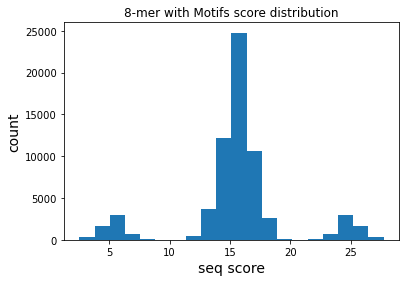

In [7]:
plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define some basic model archs for Linear and CNN

In [8]:
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix?? I think the unsqueeze adds a necessary dimension for Conv2D?
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

In [9]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
    
def quick_test8(model, oracle):
    '''Sanity check some sequence predictions against the oracle (ground truth dict)'''
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

# Single task Regression with Motifs
### Split data into train and test

In [10]:
# build DataLoader objects in PyTorch, also return pandas dfs of the train and test seqs
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif, batch_size=13)

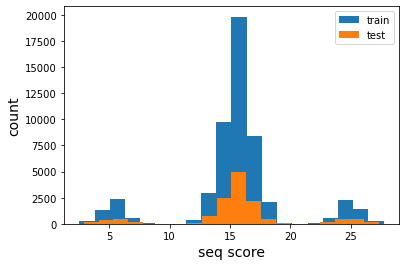

In [11]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

In [12]:
mer8motif_train_df['oh'].values[0].shape

(8, 4)

In [13]:
# inspect some stuff about a batch
for xb, yb in mer8motif_train_dl:
    break

# print some stuff that happens in the forward pass of the PyTorch model
print("xb shape:",xb.shape)
print("xb shape after forward pass:",xb.permute(0,2,1).unsqueeze(1).shape)
print(xb.permute(0,2,1).unsqueeze(1))

xb shape: torch.Size([13, 8, 4])
xb shape after forward pass: torch.Size([13, 1, 4, 8])
tensor([[[[0., 0., 0., 1., 0., 0., 0., 0.],
          [1., 0., 1., 0., 1., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 1., 0., 0., 1., 1., 1., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [1., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1.]]],


        [[[1., 0., 1., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 1., 0.],
          [0., 0., 0., 1., 0., 1., 0., 1.]]],


        [[[1., 0., 1., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 1., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 1., 0., 1., 0., 0.]]],


        [[[0., 0., 0., 1., 0., 1., 0., 1.],
          [1., 1., 0., 0., 1., 0., 1., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[1

##  Linear Model

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/cuda/CUDAFunctions.cpp:115.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


0 6.793875023990934
1 3.3187473799793468
2 1.981510016897811
3 1.1261696804691133
4 1.6846805977128358
5 0.7023500172017204
6 1.0175650500052125
7 0.5970002914795087
8 0.5386132549927626
9 0.7163647259007213
10 0.7803298995026118
11 0.5296663919302896
12 0.5009169162611705
13 0.5411686823996927
14 0.682327261950558
15 0.5582575772837518
16 0.49702554952318
17 0.5102440519855199
18 0.5216030622910632
19 0.5366919195114075


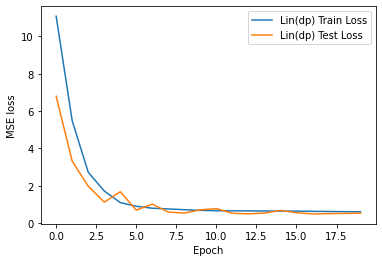

In [14]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

In [15]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_d,oracle_8mer_motif)

AAAAAAAA: pred:19.790 actual:20.000 (0.210)
CCCCCCCC: pred:16.523 actual:17.000 (0.477)
GGGGGGGG: pred:13.972 actual:14.000 (0.028)
TTTTTTTT: pred:11.395 actual:11.000 (-0.395)

AACCAACA: pred:18.868 actual:18.875 (0.007)
CCGGCGCG: pred:0.000 actual:5.500 (5.500)
GGGTAAGG: pred:15.125 actual:15.125 (-0.000)
TTTCGTTT: pred:11.789 actual:12.125 (0.336)
TGTAATAC: pred:16.083 actual:15.500 (-0.583)

TATAAAAA: pred:25.658 actual:27.750 (2.092)
CCTATCCC: pred:27.359 actual:25.875 (-1.484)
GTATGGGG: pred:23.671 actual:24.000 (0.329)
TTTATTTT: pred:19.543 actual:22.125 (2.582)

AAGCGAAA: pred:8.472 actual:8.125 (-0.347)
CGCGCCCC: pred:5.883 actual:6.250 (0.367)
GGGCGGGG: pred:4.780 actual:4.375 (-0.405)
TTGCGTTT: pred:1.835 actual:2.500 (0.665)

ATATGCGA: pred:15.173 actual:15.875 (0.702)
TGCGTATT: pred:12.446 actual:13.625 (1.179)



### CNN Model

0 0.6169636265656362
1 0.3749693442948292
2 0.04260264214420875
3 0.024384622136471967
4 0.023259644189894416
5 0.02170218680784023
6 0.01933398335858627
7 0.01627576120402459
8 0.014706319255608318
9 0.021362573964718665
10 0.013346249400199977
11 0.012904090582175844
12 0.012454442818831858
13 0.013317870092388951
14 0.011920447828504224
15 0.01113764625995612
16 0.01051346436198729
17 0.010563881960665144
18 0.010363452275387281
19 0.010457818740215117


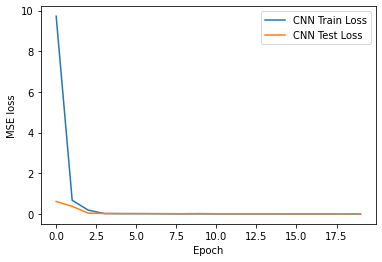

In [16]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn, 
)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [17]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:19.869 actual:20.000 (0.131)
CCCCCCCC: pred:16.986 actual:17.000 (0.014)
GGGGGGGG: pred:13.983 actual:14.000 (0.017)
TTTTTTTT: pred:10.894 actual:11.000 (0.106)

AACCAACA: pred:18.874 actual:18.875 (0.001)
CCGGCGCG: pred:5.475 actual:5.500 (0.025)
GGGTAAGG: pred:15.120 actual:15.125 (0.005)
TTTCGTTT: pred:12.090 actual:12.125 (0.035)
TGTAATAC: pred:15.462 actual:15.500 (0.038)

TATAAAAA: pred:26.797 actual:27.750 (0.953)
CCTATCCC: pred:25.891 actual:25.875 (-0.016)
GTATGGGG: pred:23.858 actual:24.000 (0.142)
TTTATTTT: pred:22.088 actual:22.125 (0.037)

AAGCGAAA: pred:8.173 actual:8.125 (-0.048)
CGCGCCCC: pred:6.229 actual:6.250 (0.021)
GGGCGGGG: pred:4.393 actual:4.375 (-0.018)
TTGCGTTT: pred:2.448 actual:2.500 (0.052)

ATATGCGA: pred:16.183 actual:15.875 (-0.308)
TGCGTATT: pred:13.508 actual:13.625 (0.117)



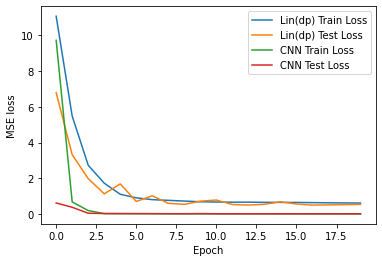

In [18]:
u.quick_loss_plot(
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label
)

In [19]:
def parity_pred(models, seqs, oracle,task,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            u.alt_parity_plot(model_name, df, pearson,task)
        u.parity_plot(model_name, df, pearson)

    return dfs

Running LinearDeep_8mer


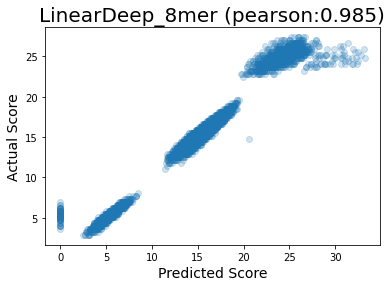

Running CNN_8mer


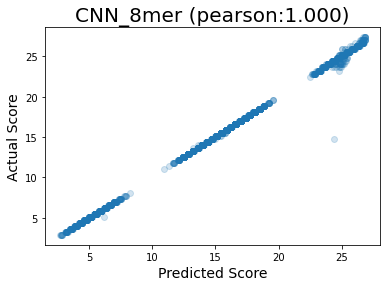

In [20]:
models = [
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

# Checkpoint 1
The models are trained in PyTorch and are working as expected: the linear model does pretty good (it's a simple task) but the CNN model is doing much better. 

I'd like to practice using Scramblers, and I expect that Scramblers should see that the models are indeed relying on the TAT and GCG motifs to predict the scoring pattern.

However, Scramblers are in Keras, not PyTorch. 

So I'm trying to use ONNX to convert the PyTorch models to Keras. Unfortunately, ONNX uses tf.Keras while scramblers just use Keras. So this will actually be 2 steps:
1. Convert PyTorch to tf.Keras (via ONNX)
2. Convert tf.Keras to Keras


## try to export to keras

In [21]:
mer8motif_model_lin_d

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=24, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): ReLU(inplace=True)
  )
)

In [22]:
mer8motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 31, kernel_size=(4, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=186, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

### Try onnx export

In [23]:
import keras
import onnx
import onnx2keras
from onnx2keras import onnx_to_keras

Using TensorFlow backend.
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [24]:
seqs = ["AAAAAAAA","TTTTTTTT","CCCCCCCC","GGGGGGGG","GGGTATGG","AAGCGAAA"]

In [25]:
def export2keras(pt_model, model_name_str,example_seqs):
    
    # make dummy input from example seqs
    ohe_seqs = [u.one_hot_encode(x) for x in example_seqs]
    ohe_seqs = [torch.from_numpy(x).unsqueeze(0).float() for x in ohe_seqs]
    dummy_input = ohe_seqs[0]
    
    # export intermediate ONNX model
    onnx_model_str = f"{model_name_str}.onnx"
    torch.onnx.export(
        pt_model, 
        dummy_input, 
        onnx_model_str, 
        input_names=['test_input'], # should this change? Does it matter?
        output_names=['test_output']
    )
    print("Done saving to onnx.")
    print("Loading to Keras...")
    
    # convert ONNX to keras
    onnx_model = onnx.load(onnx_model_str)
    k_model = onnx_to_keras(onnx_model, ['test_input'])
    
    print("\nConfirming Torch and Keras match")
    # confirm Pytorch and Keras agree
    for i in range(len(example_seqs)):
        seq = example_seqs[i]
        ohe_seq = ohe_seqs[i]
        seq_k = np.array(ohe_seq)

        res = pt_model(ohe_seq)
        res2 = k_model.predict(seq_k)
        
        print(f"{seq}: \n\tPyTorch:{res.item()} \n\tKeras  :{res2[0][0]}")
        
    # save the Keras model
    k_model_str = f"{model_name_str}.h5"
    
    k_model.save(k_model_str)
    print(f"Keras Model saved at {k_model_str}")
    return k_model


In [26]:
tf.__version__

NameError: name 'tf' is not defined

In [27]:
k_lin_d_model = export2keras(mer8motif_model_lin_d, "mer8motif_model_lin_d",seqs)

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> test_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> test_output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight lin.0.weight with shape (24, 32).
DEBUG:onnx2keras:Found weight lin.0.bias with shape (24,).
DEBUG:onnx2keras:Found weight lin.2.weight with shape (1, 24).
DEBUG:onnx2keras:Found weight lin.2.bias with shape (1,).
DEBUG:onnx2keras:Found weight 17 with shape (1,).
DEBUG:onnx2keras:Found input test_input with shape [8, 4]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Shape
DEBUG:onnx2keras:node_name: 5
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name test_input).
DEBUG:onnx2k

Done saving to onnx.
Loading to Keras...
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.
DEBUG:onnx2keras:Output TF Layer -> Tensor("13/BiasAdd:0", shape=(?, 24), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: 14
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 13).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:Output TF Layer -> Tensor("14/Relu:0", shape=(?, 24), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: 15
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (na


Confirming Torch and Keras match
AAAAAAAA: 
	PyTorch:19.789669036865234 
	Keras  :19.789670944213867
TTTTTTTT: 
	PyTorch:11.395001411437988 
	Keras  :11.395001411437988
CCCCCCCC: 
	PyTorch:16.522705078125 
	Keras  :16.522701263427734
GGGGGGGG: 
	PyTorch:13.972076416015625 
	Keras  :13.972077369689941
GGGTATGG: 
	PyTorch:22.839338302612305 
	Keras  :22.839338302612305
AAGCGAAA: 
	PyTorch:8.471780776977539 
	Keras  :8.471780776977539
Keras Model saved at mer8motif_model_lin_d.h5


In [28]:
k_cnn_model = export2keras(mer8motif_model_cnn, "mer8motif_model_cnn",seqs)

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> test_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> test_output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight conv_net.0.weight with shape (31, 1, 4, 3).
DEBUG:onnx2keras:Found weight conv_net.0.bias with shape (31,).
DEBUG:onnx2keras:Found weight conv_net.3.weight with shape (10, 186).
DEBUG:onnx2keras:Found weight conv_net.3.bias with shape (10,).
DEBUG:onnx2keras:Found weight conv_net.5.weight with shape (1, 10).
DEBUG:onnx2keras:Found weight conv_net.5.bias with shape (1,).
DEBUG:onnx2keras:Found input test_input with shape [8, 4]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Transpose
DEBUG:onnx2keras:node_name: 7
DEBUG:onnx2keras:node_params: {'perm': [0, 2, 1], 'change_ordering': False, 'name_policy': None}
DEB

Done saving to onnx.
Loading to Keras...


DEBUG:onnx2keras:Output TF Layer -> Tensor("12_2/BiasAdd:0", shape=(?, 10), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: 13
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 12).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:Output TF Layer -> Tensor("13_1/Relu:0", shape=(?, 10), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: test_output
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 13).
DEBUG:onnx2keras:Check input 1 (name conv_net.5.wei


Confirming Torch and Keras match
AAAAAAAA: 
	PyTorch:19.8690242767334 
	Keras  :19.8690242767334
TTTTTTTT: 
	PyTorch:10.894265174865723 
	Keras  :10.894265174865723
CCCCCCCC: 
	PyTorch:16.986248016357422 
	Keras  :16.986248016357422
GGGGGGGG: 
	PyTorch:13.98330020904541 
	Keras  :13.98330020904541
GGGTATGG: 
	PyTorch:24.00599479675293 
	Keras  :24.005996704101562
AAGCGAAA: 
	PyTorch:8.172531127929688 
	Keras  :8.17253303527832
Keras Model saved at mer8motif_model_cnn.h5


The models seems to be predicting the same out to ~5 decimals between PyTorch and Keras!

# Test Keras model in Scramblers
Using notebook template from optimus prime example

In [29]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores

#from optimus5_utils import load_optimus5_data, load_optimus5_predictor, animate_optimus5_examples

import utils as u
SEQ_LEN=8

In [30]:
# use same train/test sets as above
encoder = OneHotEncoder(seq_length=SEQ_LEN, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

x_train = np.array([encoder(seq[0]).reshape(1, SEQ_LEN, 4) for seq in mer8motif_train_df[['seq']].values])
x_test = np.array([encoder(seq[0]).reshape(1, SEQ_LEN, 4) for seq in mer8motif_test_df[['seq']].values])

y_train = mer8motif_train_df[['score']].values
y_test = mer8motif_test_df[['score']].values


# Apparently keras can't deal with training sets that are not 
# an exact multiple of the batch size... sooo... trim some?
train_trim = 12
test_trim = 20

x_train = x_train[:-train_trim]
x_test = x_test[:-test_trim]
y_train = y_train[:-train_trim]
y_test = y_test[:-test_trim]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(52416, 1, 8, 4)
(52416, 1)
(13088, 1, 8, 4)
(13088, 1)


In [31]:
#Define sequence template and background

#sequence_template = '$' * 50
sequence_template = '$' * SEQ_LEN

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

# This is the background? So it's a mean by position... I'll probs change this...
x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)

print(sequence_template)
print(onehot_template)
print(sequence_mask)
print(x_mean)
print(x_mean.shape)

$$$$$$$$
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[1 1 1 1 1 1 1 1]
[[0.24929416 0.25099199 0.24954216 0.25017169]
 [0.24925601 0.25061045 0.25116368 0.24896986]
 [0.24906524 0.24925601 0.24961847 0.25206028]
 [0.24996185 0.25011446 0.24923693 0.25068676]
 [0.24887448 0.2503243  0.25053415 0.25026707]
 [0.25141167 0.24965662 0.24866463 0.25026707]
 [0.25087753 0.24807325 0.25198398 0.24906524]
 [0.24977108 0.25076307 0.24998092 0.24948493]]
(8, 4)


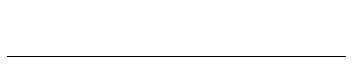

Mean KL Div against background (bits) = 1.9999891911093224


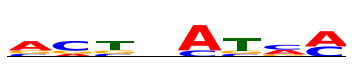

In [33]:
#Visualize background sequence distribution
plot_dna_logo(
    np.copy(x_mean), 
    sequence_template=sequence_template, 
    figsize=(5, 1), logo_height=1.0, 
    plot_start=0, plot_end=SEQ_LEN)


#Calculate mean training set kl-divergence against background
# resets one hot to almost 0 and almost 1... why?
#x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)
x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

# (train size, 50)
kl_divs = np.sum(x_train_clipped * \
                 np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), 
                                                  (x_train_clipped.shape[0], 1, 1))), axis=-1)\
            / np.log(2.0)

# train size
x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
# 1
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


# Plot test array just so I can see some letters show up
test = np.array([[.6, .2, .2, .0],
                 [.2, .6, .2, .0],
                 [.0, .2, .2, .6],
                 [.3, .2, .2, .3],
                 [.8, .2, .0, .0],
                 [.0, .2, .2, .8],
                 [.4, .4, .2, .0],
                 [.6, .4, .0, .0],
                ])
plot_dna_logo(
    np.copy(test), 
    sequence_template=sequence_template, 
    figsize=(5, 1), logo_height=1.0, 
    plot_start=0, plot_end=SEQ_LEN)

## Scramblin' Time
I changed some of the settings to try to make the smallest scrambler network as possible because the sequences are so small!

In [34]:
#Plot training statistics
def plot_training_stats(train_history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

    n_epochs_actual = len(train_history['nll_loss'])

    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green',label='nll_loss')
    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange',label='vall_nll_loss')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("NLL", fontsize=14)
    plt.xlim(1, n_epochs_actual)
    plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()

    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green',label='entropy_loss')
    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange',label='val_entropy_loss')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Entropy Loss", fontsize=14)
    plt.xlim(1, n_epochs_actual)
    plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()

    plt.tight_layout()

    plt.show()

def build_scrambler():
    #Scrambler network configuration
    network_config = {
        'n_groups' : 1,
        'n_resblocks_per_group' : 1, # resblock has 2 conv layers
        'n_channels' : 32, # num filters
        'window_size' : 3, # kernel size
        'dilation_rates' : [1],
        'drop_rate' : 0.0,
        'norm_mode' : 'instance', # some sort of normalization
        'mask_smoothing' : False, # "smooth" not referenced in paper or github instructions
        'mask_smoothing_window_size' : 5,
        'mask_smoothing_std' : 1.,
        'mask_drop_scales' : [1, 5],
        'mask_min_drop_rate' : 0.0,
        'mask_max_drop_rate' : 0.5,
        'label_input' : False
    }

    #Initialize scrambler
    scrambler = Scrambler(
        scrambler_mode='inclusion',
        input_size_x=1,
        input_size_y=SEQ_LEN,
        n_out_channels=4,
        input_templates=[onehot_template],
        input_backgrounds=[x_mean],
        batch_size=32,
        n_samples=32,
        sample_mode='gumbel',
        zeropad_input=False,
        mask_dropout=False,
        network_config=network_config
    )
    
    return scrambler

def train_scrambler_on_model(model, n_epochs=10):
    # init scrambler object
    scr = build_scrambler()
    
    # train scrambler on model
    train_history = scr.train(
        model,
        x_train,
        y_train,
        x_test,
        y_test,
        n_epochs,
        monitor_test_indices=np.arange(32).tolist(),
        monitor_batch_freq_dict={0 : 1, 100 : 5, 469 : 10},
        nll_mode='reconstruction',
        predictor_task='regression',
        entropy_mode='target',
        entropy_bits=0.125,
        entropy_weight=10.
    )
    
    # plot 
    plot_training_stats(train_history)
    
    return scr, train_history

def save_scrambler(scrambler, train_history, model_name,save_dir="saved_models"):
    #Save scrambler checkpoint

    #model_name = 'optimus5_inclusion_scrambler_bits_0125_epochs_10'
    #model_name = 'mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '.h5')

    scrambler.save_model(model_path)

    pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))



In [35]:
lin_d_scr, lin_d_scr_train_hist = train_scrambler_on_model(k_lin_d_model)
model_name = 'mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10'
save_scrambler(lin_d_scr, lin_d_scr_train_hist, model_name)

SCRAMBLER INITIATED!!

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

IN SCRAMBLER TRAIN!


ValueError: ('Could not interpret optimizer identifier:', <keras.optimizers.SGD object at 0x7f64ac197a50>)

# Error! 
I think this has to do with ONNX using tf.keras and Scramblers using regular keras.

In [36]:
k_lin_d_model

In [37]:
k_cnn_model

# try to Save as h5 and reload in keras (remove tensorflow)

Optimus model loaded in Scrambler example is `keras.engine.training.Model`

In [38]:
# conf = k_lin_d_model.get_config()
# k_lin_no_tf = keras.models.Model.from_config(conf)
# k_lin_no_tf # try saving then reloading
# ^^ Ran in scrambler but must not have had weights? Scrambler didn't learn anything...

In [39]:
k_lin_d_model.save("k_lin_d.h5")
k_lin_no_tf = keras.models.load_model("k_lin_d.h5")
k_lin_no_tf

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


SCRAMBLER INITIATED!!
IN SCRAMBLER TRAIN!
predictor is compiled??
Scrambler has created inputs...
Starting to build lambda stuff?
About to predict stuff...
Inflating?
Calculating NLL / error?
Calculated NLL?: Tensor("nll/mul:0", shape=(32,), dtype=float32)
Made Loss Model
Compiled loss model: <keras.engine.training.Model object at 0x7f63a80b1b50>
label train and test? [] []
APPENDING to callbacks
Fitting loss model...
	group train 1 (52416, 1)
	x train 1 (52416, 1, 8, 4)
	drop train 0 []
	label train 0 []

n epochs: 10
batch size: 32
callbacks: [<scrambler.models.scrambler_models.ScramblerMonitor object at 0x7f63700496d0>]
Train on 52416 samples, validate on 13088 samples
Epoch 1/10
52416/52416 [==============================] - 45s 857us/step - loss: 11.6766 - nll_loss: 8.0656 - entropy_loss: 3.6110 - val_loss: 8.2892 - val_nll_loss: 5.8985 - val_entropy_loss: 2.3907
Epoch 2/10
52416/52416 [==============================] - 36s 691us/step - loss: 7.9401 - nll_loss: 5.7615 - entropy_lo

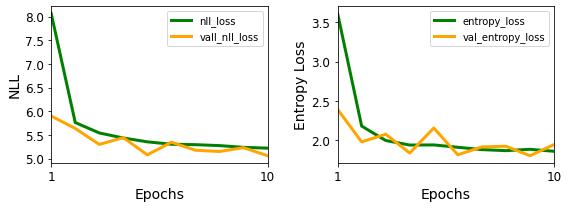

Saved scrambler model at saved_models/mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10.h5 


In [40]:
lin_d_scr, lin_d_scr_train_hist = train_scrambler_on_model(k_lin_no_tf)
model_name = 'mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10'
save_scrambler(lin_d_scr, lin_d_scr_train_hist, model_name)

## Eval scrambler results?
So the scrambler ran on the linear model - now check the scrambler results by visualizing some sequences and their importances

In [41]:
# get seqs from test df that are ineresting to spot check
test_df = mer8motif_test_df.reset_index()

tat = list(test_df[test_df['seq'].str.contains("TAT")].index)
gcg = list(test_df[test_df['seq'].str.contains("GCG")].index)

print("Num TAT:",len(tat))
print("Num TAT:",len(gcg))

# Show some examples
list_idx = 2
g = gcg[list_idx]
print(f'GCG example idx {g}: {test_df.loc[g]["seq"]}')

list_idx = 1145
t = tat[list_idx]
print(f'TAT example idx {t}: {test_df.loc[t]["seq"]}')

# some idxs I checked and think are interesting?
ixs = [4,133,97,99,13074,13075,578,579,438,439]

Num TAT: 1146
Num TAT: 1124
GCG example idx 133: AAAGCGAA
TAT example idx 13074: TTTTATAG


In [60]:
def viz_scrambler_results(model, scrambler, cnn=False, verbose=False):
    #Interpret the test set using the trained scrambler
    pwm_test, sample_test, importance_scores_test = scrambler.interpret(x_test)
    
    if verbose:
        print("x_test:",x_test.shape)
        print("pwm_test:",pwm_test.shape)
        print("sample_test:",sample_test.shape)
        print("importance_scores_test:",importance_scores_test.shape)
        
    
    #Visualize a few reconstructed sequence patterns
    plot_examples = np.arange(5).tolist()
    save_examples = []

    importance_scores_test *= sequence_mask[None, None, :, None]

    for test_ix in ixs :
        #seq = x_test2[test_ix:test_ix+1, ...].flatten().reshape(1,-1)
        
        seq = x_test[test_ix:test_ix+1, ...]
        seq1 = x_test[test_ix:test_ix+1, ...][0]#.reshape(1,-1)
        
        print("Test sequence " + str(test_ix) + ":")
        print("seq",seq.shape,seq)
        print("seq1",seq1.shape,seq1)
        sample_seqs = sample_test[test_ix, ...]
        #x=           [sample_test[test_ix, ...]], batch_size=32)
        
        # reshape
        #sample_seqs = np.array([x.flatten().reshape(1,-1) for x in sample_seqs])

    #     y_test_hat_ref = k_reload.predict(x=[seq], batch_size=1)[0, 0]
    #     y_test_hat = k_reload.predict(x=[sample_seqs], batch_size=32)[:32, 0].tolist()
        #y_test_hat_ref = model.predict(x=[seq1])[0, 0]
        
        #y_test_hat = [model.predict(x=[ss])[0, 0] for ss in sample_seqs]
        #y_test_hat = model.predict(x=[sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
        
        # BLERGH! Linear model expect 1,8,4 but CNN wants 1,1,8,4. I'm not gonna bother
        # fixing this in a nice way now. I'll come back to it. FOr now, these are the lines
        # that work for each type:
    
        if not cnn:
        # linear model version
            y_test_hat_ref = model.predict(x=[seq1])[0, 0]
            y_test_hat = [model.predict(x=[ss])[0, 0] for ss in sample_seqs]
        
        # cnn model version
        else:
            y_test_hat_ref = model.predict(x=[seq])[0, 0]
            y_test_hat = model.predict(x=[sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
        
        print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
        print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))

        save_figs = False
        if save_examples is not None and test_ix in save_examples :
            save_figs = True

        # Original seq
        plot_dna_logo(x_test[test_ix, 0, :, :], 
                      sequence_template=sequence_template, 
                      figsize=(5, 1), 
                      plot_start=0, plot_end=SEQ_LEN, 
                      plot_sequence_template=True, 
                      save_figs=save_figs, 
                      fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence"
        )
        # PWM
        plot_dna_logo(pwm_test[test_ix, 0, :, :], 
                      sequence_template=sequence_template, 
                      figsize=(5, 1), 
                      plot_start=0, plot_end=SEQ_LEN, 
                      plot_sequence_template=True, 
                      save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm"
        )
        # importance scores
        plot_dna_importance_scores(importance_scores_test[test_ix, 0, :, :].T,
                                   encoder.decode(x_test[test_ix, 0, :, :]), 
                                   figsize=(5, 1), 
                                   score_clip=None, 
                                   sequence_template=sequence_template, 
                                   plot_start=0, plot_end=SEQ_LEN, 
                                   save_figs=save_figs, 
                                   fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores"
        )
  

In [61]:
k_lin_no_tf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
12 (Reshape)                 (None, 32)                0         
_________________________________________________________________
13 (Dense)                   (None, 24)                792       
_________________________________________________________________
14 (Activation)              (None, 24)                0         
_________________________________________________________________
15 (Dense)                   (None, 1)                 25        
_________________________________________________________________
test_output (Activation)     (None, 1)                 0         
Total params: 817
Trainable params: 0
Non-trainable params: 817
_________________________________________________________________


13088/13088 [==============================] - 2s 185us/step
Test sequence 4:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]]]
 - Prediction (original) = 18.9
 - Predictions (scrambled) = [16.9, 14.3, 15.6, 17.3, 16.4, 18.1, 15.1, 21.6, 15.7, 16.0, 16.7, 17.2, 16.0, 19.1, 14.6, 17.1, 17.6, 15.1, 12.5, 17.2, 22.7, 18.0, 17.2, 15.5, 16.5, 19.4, 18.9, 13.7, 16.3, 19.9, 17.1, 15.7]


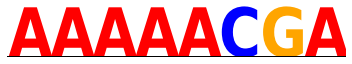

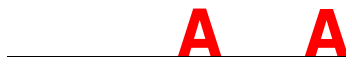

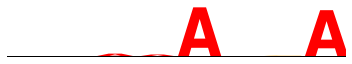

Test sequence 133:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]]
 - Prediction (original) = 8.49
 - Predictions (scrambled) = [7.03, 4.33, 4.91, 6.87, 5.4, 5.12, 6.96, 10.1, 5.54, 5.37, 3.88, 7.02, 7.78, 6.04, 2.9, 5.22, 8.18, 8.99, 13.6, 6.76, 6.65, -0.0, 5.71, 13.8, 14.6, 7.84, 13.7, 14.5, 7.26, 2.71, 3.23, 4.84]


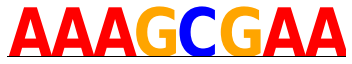

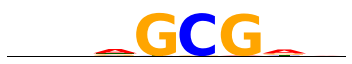

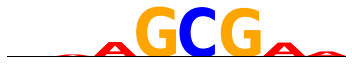

Test sequence 97:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]]]
 - Prediction (original) = 26.2
 - Predictions (scrambled) = [24.7, 23.8, 24.5, 25.1, 22.5, 23.9, 20.9, 25.1, 22.7, 23.8, 23.8, 24.5, 25.8, 25.3, 22.7, 24.3, 23.5, 22.6, 24.4, 25.3, 23.5, 27.9, 23.6, 25.3, 24.4, 24.7, 22.5, 25.4, 25.4, 25.4, 23.0, 23.0]


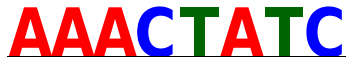

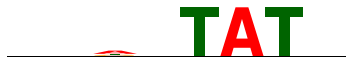

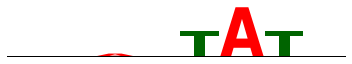

Test sequence 99:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]]
 - Prediction (original) = 18.4
 - Predictions (scrambled) = [15.8, 22.3, 19.2, 16.1, 16.0, 22.6, 17.3, 16.5, 16.6, 17.1, 16.7, 17.3, 17.1, 16.7, 22.9, 15.4, 16.6, 16.2, 16.4, 15.3, 16.5, 15.7, 17.8, 17.9, 12.5, 12.5, 18.2, 15.6, 16.9, 19.9, 15.2, 17.4]


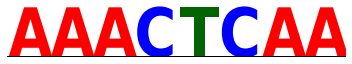

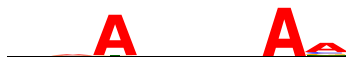

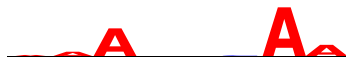

Test sequence 13074:
seq (1, 1, 8, 4) [[[[0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]]]]
seq1 (1, 8, 4) [[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]]]
 - Prediction (original) = 22.8
 - Predictions (scrambled) = [25.4, 18.3, 22.4, 22.2, 16.4, 23.4, 21.6, 23.9, 22.6, 15.3, 21.4, 21.3, 24.7, 22.6, 21.6, 24.0, 24.7, 19.6, 12.2, 24.4, 25.2, 24.7, 22.0, 23.1, 13.9, 22.9, 25.9, 22.5, 15.8, 19.5, 22.1, 23.5]


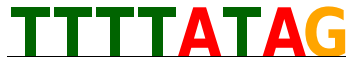

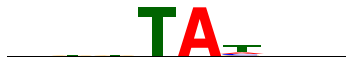

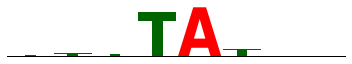

Test sequence 13075:
seq (1, 1, 8, 4) [[[[0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]]]]
seq1 (1, 8, 4) [[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]]
 - Prediction (original) = 13.4
 - Predictions (scrambled) = [14.3, 13.9, 16.3, 15.2, 11.3, 13.8, 21.6, 13.5, 13.7, 15.6, 13.8, 14.3, 12.9, 13.5, 11.9, 15.2, 15.8, 14.3, 14.3, 19.0, 14.0, 13.4, 11.4, 14.1, 14.8, 13.9, 13.4, 13.6, 15.3, 14.4, 16.0, 14.6]


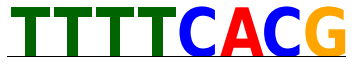

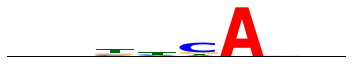

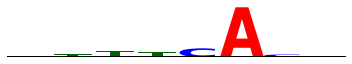

Test sequence 578:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 1. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 0. 0. 1.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]]]
 - Prediction (original) = 25.4
 - Predictions (scrambled) = [22.0, 23.0, 28.6, 22.8, 24.0, 21.9, 22.8, 22.4, 19.0, 23.4, 21.2, 21.1, 21.0, 25.7, 23.5, 19.7, 26.3, 22.9, 20.9, 23.4, 24.8, 21.0, 24.2, 26.3, 23.0, 26.4, 25.3, 23.3, 22.6, 27.6, 23.3, 26.0]


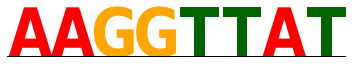

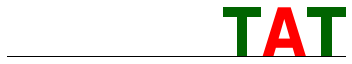

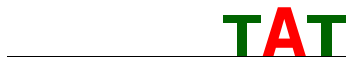

Test sequence 579:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 1. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]]]
 - Prediction (original) = 14.5
 - Predictions (scrambled) = [14.4, 14.8, 15.0, 13.8, 13.2, 13.2, 20.0, 15.8, 15.3, 18.2, 15.4, 22.1, 14.8, 18.2, 15.7, 15.5, 16.8, 14.1, 7.92, 16.9, 11.7, 15.4, 14.5, 13.0, 17.1, 12.1, 14.8, 13.6, 16.3, 13.7, 21.6, 21.3]


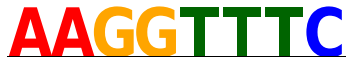

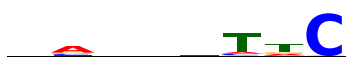

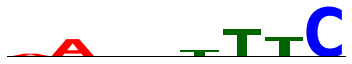

Test sequence 438:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]]
 - Prediction (original) = 7.8
 - Predictions (scrambled) = [6.74, 7.54, 4.61, 6.46, 6.17, 6.4, 7.02, -0.0, 7.6, 7.19, 8.23, 5.41, 0.1, 8.22, 3.56, 6.66, 7.39, 5.52, 6.74, 7.44, 5.61, 4.37, 6.95, 5.91, 5.24, 7.18, 7.53, 3.32, 2.32, 6.02, 8.25, 5.53]


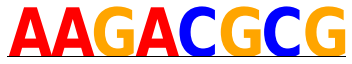

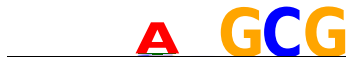

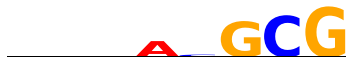

Test sequence 439:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 1. 0.]
   [0. 1. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]]]
 - Prediction (original) = 16.9
 - Predictions (scrambled) = [16.4, 15.4, 16.6, 16.6, 15.4, 17.7, 15.4, 14.0, 14.3, 12.6, 17.0, 14.7, 7.69, 16.6, 15.1, 11.2, 15.3, 13.9, 15.4, 15.5, 14.0, 16.1, 12.0, 14.8, 16.7, 16.2, 14.4, 14.7, 13.9, 14.7, 15.5, 13.5]


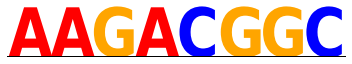

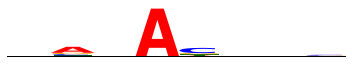

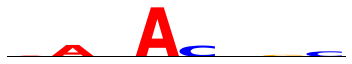

In [62]:
viz_scrambler_results(k_lin_no_tf, lin_d_scr)

# Checkpoint 2
### Scramblers working-ish for linear model!
Running the scrambler on the linear model, it seems to highlight GCGs and TATs when present, though it is not perfect. Some other surrounding letters get lumped in too.

# Next: run scramblers on the CNN model

In [63]:
k_cnn_model.save("k_cnn.h5")
k_cnn_no_tf = keras.models.load_model("k_cnn.h5")
k_cnn_no_tf

TypeError: ('Keyword argument not understood:', 'module')

# Error! Can't reload tf.keras into Keras for CNNs
I've tried tracing the reason for this and best I can tell, it's that ONNX creates a lamba layer for the CNN model when translating the `unsqueeze()` command from PyTorch to keras. However this lambda layer is defined, it works in tf.keras but not in regular keras.

In [64]:
k_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, None)              0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0         
__________

In [65]:
# I think this is the layer causing issues
k_cnn_model.get_config()['layers'][2]

{'name': '8',
 'class_name': 'Lambda',
 'config': {'name': '8',
  'trainable': True,
  'dtype': 'float32',
  'function': ('4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
   (1,),
   None),
  'module': 'onnx2keras.reshape_layers',
  'function_type': 'lambda',
  'output_shape': None,
  'output_shape_type': 'raw',
  'output_shape_module': None,
  'arguments': {}},
 'inbound_nodes': [[['7', 0, 0, {}]]]}

### ^^ keras doesn't know what a "module" is? Must be a tf.keras thing...

# Other tried to convert tf.keras to Keras Model
ONNX uses tf.keras, but scramblers uses Keras. We need to convert it before using in scramblers, but for CNNs, I can't seem to just use `keras.models.load_model()`... there's formatting incompatibility

Things that did not work:
* Just using tf.keras.Model in scramblers - broke in scrambler as above with the SGD error
* Just recasting as a keras model - broke in scramblers
  * `cnn_test = keras.models.Model(k_lin_d_model)`

* saving and reloading from json or config file
  * keras still doesn't know about 'module' 
  
Current thing that is partially working to at least load into scramblers:
1. make tf.keras model as json object
2. Delete part of json that keras doesn't recognize
  * `del json_['config']['layers'][2]['config']['module']`
  * `del json_['config']['layers'][2]['config']['output_shape_module']`
    * I believe these have to do with the Unsqueeze function that happens in the pytorch cnn... Not sure how to get this to work in keras
3. convert to json string
4. load into keras.Model
5. save weights from tf.keras model
6. load weights into keras.Model

This seems to preserve the predictions still and can go into scramblers, but then it breaks at scrambler prediction time with dimension mismatches. And thus I'm stuck again.



### Demo of json manual deletions

In [66]:
import json

In [67]:
kjson = k_cnn_model.to_json()
json_obj = json.loads(kjson)

In [68]:
json_obj['config']['layers'][2]['config']

{'name': '8',
 'trainable': True,
 'dtype': 'float32',
 'function': ['4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
  [1],
  None],
 'module': 'onnx2keras.reshape_layers',
 'function_type': 'lambda',
 'output_shape': None,
 'output_shape_type': 'raw',
 'output_shape_module': None,
 'arguments': {}}

In [69]:
# deleting things that seem to be unsupported by keras but are created in tf.keras
del json_obj['config']['layers'][2]['config']['module']
del json_obj['config']['layers'][2]['config']['output_shape_module']

# json object with problem "module" lines deleted
json_obj['config']['layers'][2]['config']

{'name': '8',
 'trainable': True,
 'dtype': 'float32',
 'function': ['4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
  [1],
  None],
 'function_type': 'lambda',
 'output_shape': None,
 'output_shape_type': 'raw',
 'arguments': {}}

In [70]:
#Full JSON object:
json_obj

{'class_name': 'Model',
 'config': {'name': 'model_1',
  'layers': [{'name': 'test_input',
    'class_name': 'InputLayer',
    'config': {'batch_input_shape': [None, 8, 4],
     'dtype': 'float32',
     'sparse': False,
     'name': 'test_input'},
    'inbound_nodes': []},
   {'name': '7',
    'class_name': 'Permute',
    'config': {'name': '7',
     'trainable': True,
     'dtype': 'float32',
     'dims': [2, 1]},
    'inbound_nodes': [[['test_input', 0, 0, {}]]]},
   {'name': '8',
    'class_name': 'Lambda',
    'config': {'name': '8',
     'trainable': True,
     'dtype': 'float32',
     'function': ['4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
      [1],
      None],
     'f

In [71]:
# convert json to string and load into keras
json_str = json.dumps(json_obj)
jtest = keras.models.model_from_json(json_str)
jtest

In [72]:
jtest.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, 186)               0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0         
__________

### But wait! the newly loaded keras model doesn't have weights! 
Need to add from the tf.keras model?

In [73]:
# load weights into empty jtest
print("Before:",jtest.get_weights())
k_cnn_model.save_weights('k_cnn_model_weights.h5')
jtest.load_weights('k_cnn_model_weights.h5')
print("After:",jtest.get_weights())


Before: [array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0.,

### Quick check to make sure previous tf.keras model makes the same predictions as the newly weight-loaded `jtest`

In [74]:
print(k_cnn_model)
print(jtest)

In [76]:
x_train.shape

(52416, 1, 8, 4)

In [77]:
ohe_seqs = [u.one_hot_encode(x) for x in seqs]
ohe_seqs = [torch.from_numpy(x).unsqueeze(0).float() for x in ohe_seqs]

for i in range(len(seqs)):
    seq = seqs[i]
    ohe_seq = ohe_seqs[i]
    seq_k = np.array(ohe_seq)

    res2 = k_cnn_model.predict(seq_k)
    res3 = jtest.predict(seq_k)
    print(f"{seq}: tf.keras: {res2}  reg keras: {res3}")


AAAAAAAA: tf.keras: [[19.869024]]  reg keras: [[19.869024]]
TTTTTTTT: tf.keras: [[10.894265]]  reg keras: [[10.894265]]
CCCCCCCC: tf.keras: [[16.986248]]  reg keras: [[16.986248]]
GGGGGGGG: tf.keras: [[13.9833]]  reg keras: [[13.9833]]
GGGTATGG: tf.keras: [[24.005997]]  reg keras: [[24.005997]]
AAGCGAAA: tf.keras: [[8.172533]]  reg keras: [[8.172531]]


### Yes, these look the same. Save.

In [78]:
jtest.save("jtest_cnn.h5")

In [79]:
jtest_reload = keras.models.load_model("jtest_cnn.h5")

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [80]:
for i in range(len(seqs)):
    seq = seqs[i]
    ohe_seq = ohe_seqs[i]
    seq_k = np.array(ohe_seq)

    res2 = k_cnn_model.predict(seq_k)
    res3 = jtest.predict(seq_k)
    res4 = jtest_reload.predict(seq_k)
    print(f"{seq}: tf.keras: {res2}  reg keras: {res3}   keras reload: {res4}")

AAAAAAAA: tf.keras: [[19.869024]]  reg keras: [[19.869024]]   keras reload: [[19.869024]]
TTTTTTTT: tf.keras: [[10.894265]]  reg keras: [[10.894265]]   keras reload: [[10.894265]]
CCCCCCCC: tf.keras: [[16.986248]]  reg keras: [[16.986248]]   keras reload: [[16.986248]]
GGGGGGGG: tf.keras: [[13.9833]]  reg keras: [[13.9833]]   keras reload: [[13.9833]]
GGGTATGG: tf.keras: [[24.005997]]  reg keras: [[24.005997]]   keras reload: [[24.005997]]
AAGCGAAA: tf.keras: [[8.172533]]  reg keras: [[8.172531]]   keras reload: [[8.172531]]


# Try to use jtest in Scramblers

In [81]:
cnn_scr, cnn_scr_train_hist = train_scrambler_on_model(jtest)
model_name = 'mer8motif_model_cnn_inclusion_scrambler_bits_0125_epochs_10'
save_scrambler(cnn_scr, cnn_scr_train_hist, model_name)

SCRAMBLER INITIATED!!
IN SCRAMBLER TRAIN!
predictor is compiled??
Scrambler has created inputs...
Starting to build lambda stuff?
About to predict stuff...


ValueError: Dimension must be 4 but is 3 for 'model_1_1/7/transpose' (op: 'Transpose') with input shapes: [?,1,8,4], [3].

# Error! And this is where I'm really stuck
There's a dimension mismatch that happens inside `scrambler.train`. Specifically when `predictor(scrambler_inputs)` is called. 

I've tried returning early both what `predictor` and `scrambler_inputs` are... 


`scrambler_inputs` looked like: `<tf.Tensor 't_scrambler_input_0_3:0' shape=(?, 1, 8, 4) dtype=float32>`

`predictor` was still a `keras.engine.training.Model`

But for some reason this shape can't be called by this model?

Manually calling `predictor(scrambler_inputs)` in the notebook gives the same error:

`InvalidArgumentError: Dimension must be 4 but is 3 for 'model_1_2/7/transpose' (op: 'Transpose') with input shapes: [?,1,8,4], [3].`

### Again, I think it is something to do with how ONNX transfers `unsqueeze` from pytorch to keras... but I can't tell if I'm setting up the keras model incorrectly (totally possible, I manually deleted some things from JSON...) or if Scrambers for some reason can't handle input to a CNN built the way mine is? 

### I'm not sure if I should change my PyTorch model, because it's working and I can do test predictions with the keras models and get the same numbers out:

In [82]:
for i in range(len(seqs)):
    seq = seqs[i]
    ohe_seq = ohe_seqs[i]
    seq_k = np.array(ohe_seq)

    res1 = mer8motif_model_cnn(ohe_seq)
    res2 = k_cnn_model.predict(seq_k)
    res3 = jtest.predict(seq_k)
    res4 = jtest_reload.predict(seq_k)
    print(f"{seq}:")
    print(f"\tPyTorch:\t{res1.item()} \n\ttf.keras:\t{res2[0][0]}  \n\treg keras:\t{res3[0][0]}   \n\tkeras reload:\t{res4[0][0]}")

AAAAAAAA:
	PyTorch:	19.8690242767334 
	tf.keras:	19.8690242767334  
	reg keras:	19.8690242767334   
	keras reload:	19.8690242767334
TTTTTTTT:
	PyTorch:	10.894265174865723 
	tf.keras:	10.894265174865723  
	reg keras:	10.894265174865723   
	keras reload:	10.894265174865723
CCCCCCCC:
	PyTorch:	16.986248016357422 
	tf.keras:	16.986248016357422  
	reg keras:	16.986248016357422   
	keras reload:	16.986248016357422
GGGGGGGG:
	PyTorch:	13.98330020904541 
	tf.keras:	13.98330020904541  
	reg keras:	13.98330020904541   
	keras reload:	13.98330020904541
GGGTATGG:
	PyTorch:	24.00599479675293 
	tf.keras:	24.005996704101562  
	reg keras:	24.005996704101562   
	keras reload:	24.005996704101562
AAGCGAAA:
	PyTorch:	8.172531127929688 
	tf.keras:	8.17253303527832  
	reg keras:	8.172531127929688   
	keras reload:	8.172531127929688


### But something about the `scrambler_inputs` or the call to the `predictor()` inside `scrambler.train` is unhappy with the dimensions... :-/

Did I go wrong:
* Deleting things from JSON and expecting it to work?
* Are there other ways to convert tf.keras.Model into regular keras.Model?
* Is my PyTorch set up bad?
* Does Scrambler code need to be edited?

Happy for any ideas!

In [83]:
# some final prints in case its helpful
print("TF Keras model")
print(k_cnn_model)
print(k_cnn_model.summary())
k_cnn_model.get_config()

TF Keras model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, None)              0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0     

{'name': 'model_1',
 'layers': [{'name': 'test_input',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 8, 4),
    'dtype': 'float32',
    'sparse': False,
    'name': 'test_input'},
   'inbound_nodes': []},
  {'name': '7',
   'class_name': 'Permute',
   'config': {'name': '7',
    'trainable': True,
    'dtype': 'float32',
    'dims': (2, 1)},
   'inbound_nodes': [[['test_input', 0, 0, {}]]]},
  {'name': '8',
   'class_name': 'Lambda',
   'config': {'name': '8',
    'trainable': True,
    'dtype': 'float32',
    'function': ('4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
     (1,),
     None),
    'module': 'onnx2keras.reshape_layers',
    'function_type':

In [84]:
print("Regular Keras model")
print(jtest)
print(jtest.summary())
jtest.get_config()

Regular Keras model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, 186)               0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0

{'name': 'model_1',
 'layers': [{'name': 'test_input',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 8, 4),
    'dtype': 'float32',
    'sparse': False,
    'name': 'test_input'},
   'inbound_nodes': []},
  {'name': '7',
   'class_name': 'Permute',
   'config': {'name': '7', 'trainable': True, 'dims': (2, 1)},
   'inbound_nodes': [[['test_input', 0, 0, {}]]]},
  {'name': '8',
   'class_name': 'Lambda',
   'config': {'name': '8',
    'trainable': True,
    'function': ('4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
     (1,),
     None),
    'function_type': 'lambda',
    'output_shape': None,
    'output_shape_type': 'raw',
    'arguments': {}},
   'inbo

In [85]:
k_cnn_model

## Recs from Johannes

In [86]:
# make input with new layer with 4 dimensions, then a lambda layer to remove it?
new_input = Input(shape=(1, SEQ_LEN, 4))
removed_ax = Lambda(lambda x: x[:, 0, ...])(new_input)
new_output = jtest_reload(removed_ax)
new_jtest_reload = Model([new_input], [new_output])

In [87]:
new_jtest_reload.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 8, 4)           0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 8, 4)              0         
_________________________________________________________________
model_1 (Model)              (None, 1)                 2284      
Total params: 2,284
Trainable params: 2,284
Non-trainable params: 0
_________________________________________________________________


In [88]:
jtest_reload.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, 186)               0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0         
__________

SCRAMBLER INITIATED!!
IN SCRAMBLER TRAIN!
predictor is compiled??
Scrambler has created inputs...
Starting to build lambda stuff?
About to predict stuff...
Inflating?
Calculating NLL / error?
Calculated NLL?: Tensor("nll_1/mul:0", shape=(32,), dtype=float32)
Made Loss Model
Compiled loss model: <keras.engine.training.Model object at 0x7f62c1d7d310>
label train and test? [] []
APPENDING to callbacks
Fitting loss model...
	group train 1 (52416, 1)
	x train 1 (52416, 1, 8, 4)
	drop train 0 []
	label train 0 []

n epochs: 10
batch size: 32
callbacks: [<scrambler.models.scrambler_models.ScramblerMonitor object at 0x7f62c1c83e10>]
Train on 52416 samples, validate on 13088 samples
Epoch 1/10
52416/52416 [==============================] - 50s 962us/step - loss: 10.0520 - nll_loss: 7.5953 - entropy_loss: 2.4567 - val_loss: 6.4776 - val_nll_loss: 5.0591 - val_entropy_loss: 1.4185
Epoch 2/10
52416/52416 [==============================] - 46s 870us/step - loss: 6.1824 - nll_loss: 4.7630 - entropy_

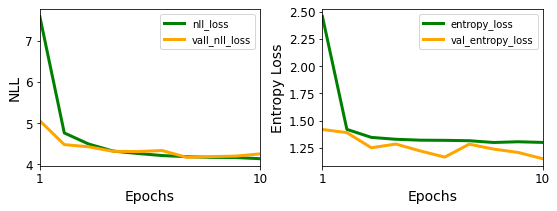

Saved scrambler model at saved_models/mer8motif_model_cnn_inclusion_scrambler_bits_0125_epochs_10.h5 


In [89]:
cnn_scr, cnn_scr_train_hist = train_scrambler_on_model(new_jtest_reload)
model_name = 'mer8motif_model_cnn_inclusion_scrambler_bits_0125_epochs_10'
save_scrambler(cnn_scr, cnn_scr_train_hist, model_name)

13088/13088 [==============================] - 2s 176us/step
Test sequence 4:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]]]
 - Prediction (original) = 18.8
 - Predictions (scrambled) = [17.0, 15.8, 16.3, 17.1, 16.2, 16.6, 17.4, 17.8, 18.1, 16.7, 16.9, 17.3, 14.3, 15.1, 14.6, 17.5, 16.5, 15.1, 17.8, 17.0, 15.6, 16.3, 16.4, 16.2, 22.8, 16.8, 15.3, 15.6, 16.7, 17.4, 16.1, 14.1]


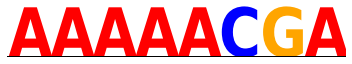

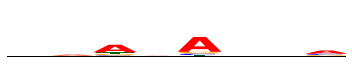

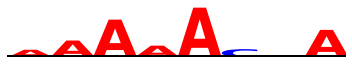

Test sequence 133:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]]
 - Prediction (original) = 8.22
 - Predictions (scrambled) = [6.05, 14.8, 13.0, 6.72, 6.6, 15.5, 7.87, 6.92, 5.22, 6.32, 5.8, 14.5, 7.23, 6.63, 12.4, 5.39, 6.34, 11.5, 5.64, 15.9, 6.85, 13.2, 6.63, 6.56, 5.87, 11.3, 6.68, 6.55, 6.92, 13.0, 6.93, 11.9]


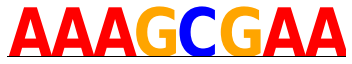

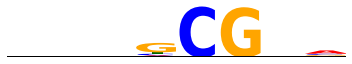

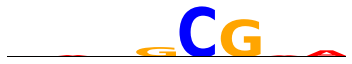

Test sequence 97:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]]]
 - Prediction (original) = 26.5
 - Predictions (scrambled) = [23.2, 25.3, 25.7, 24.4, 25.1, 26.0, 26.1, 25.7, 24.7, 24.1, 25.5, 24.4, 25.7, 26.1, 24.9, 25.4, 25.3, 25.7, 25.7, 25.2, 25.7, 24.3, 25.7, 25.6, 25.7, 24.3, 25.6, 25.7, 24.3, 25.3, 23.9, 26.4]


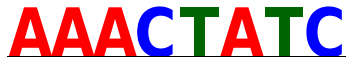

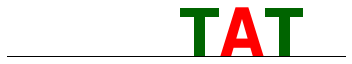

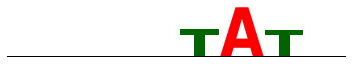

Test sequence 99:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]]
 - Prediction (original) = 18.1
 - Predictions (scrambled) = [17.1, 15.3, 14.8, 13.8, 17.6, 18.0, 17.3, 17.4, 17.6, 16.7, 14.2, 17.4, 16.5, 16.6, 15.9, 16.5, 18.3, 16.5, 16.5, 15.8, 18.0, 16.9, 14.0, 17.3, 22.6, 17.0, 15.8, 19.1, 17.0, 16.4, 15.5, 15.4]


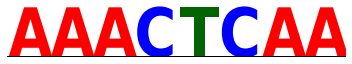

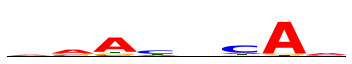

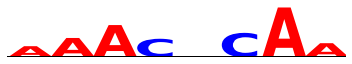

Test sequence 13074:
seq (1, 1, 8, 4) [[[[0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]]]]
seq1 (1, 8, 4) [[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]]]
 - Prediction (original) = 23.6
 - Predictions (scrambled) = [26.3, 19.2, 25.5, 23.8, 22.8, 22.7, 22.3, 25.8, 17.8, 23.1, 23.9, 25.1, 25.0, 26.3, 25.8, 14.7, 17.6, 25.5, 25.2, 23.6, 14.8, 16.9, 25.2, 25.9, 26.4, 21.8, 25.0, 20.8, 24.5, 25.4, 26.3, 22.9]


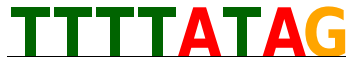

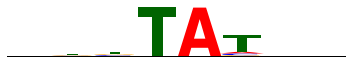

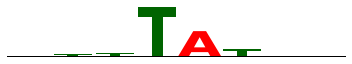

Test sequence 13075:
seq (1, 1, 8, 4) [[[[0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]]]]
seq1 (1, 8, 4) [[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]]
 - Prediction (original) = 13.9
 - Predictions (scrambled) = [18.6, 14.9, 14.6, 18.1, 15.9, 13.2, 14.1, 16.8, 14.8, 15.9, 15.4, 15.3, 14.2, 15.7, 22.0, 19.9, 13.7, 14.4, 15.8, 15.0, 14.9, 15.3, 15.7, 14.8, 16.2, 20.9, 14.5, 14.3, 15.8, 15.6, 16.4, 14.6]


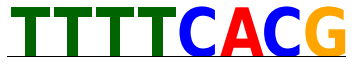

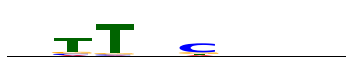

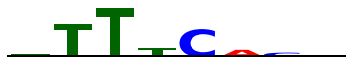

Test sequence 578:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 1. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [1. 0. 0. 0.]
   [0. 0. 0. 1.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]]]
 - Prediction (original) = 25.1
 - Predictions (scrambled) = [25.7, 24.9, 24.9, 26.0, 24.9, 25.0, 25.5, 25.7, 24.2, 26.0, 25.1, 25.7, 24.6, 26.1, 24.3, 25.0, 24.6, 25.3, 23.4, 25.7, 25.3, 25.0, 24.7, 24.5, 25.8, 25.8, 26.2, 25.3, 24.5, 24.5, 24.9, 26.0]


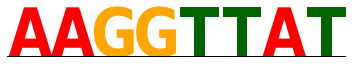

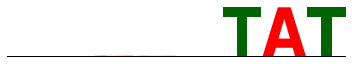

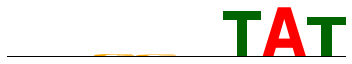

Test sequence 579:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 1. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]]]
 - Prediction (original) = 14.7
 - Predictions (scrambled) = [17.5, 14.7, 13.8, 15.1, 23.6, 22.7, 14.1, 14.9, 18.7, 16.5, 15.0, 15.6, 16.3, 22.0, 14.1, 15.9, 15.0, 15.5, 15.4, 15.0, 15.2, 15.2, 14.3, 16.3, 13.4, 15.3, 15.1, 14.6, 17.5, 14.9, 17.7, 10.9]


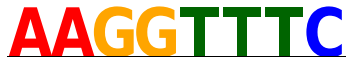

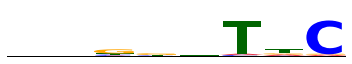

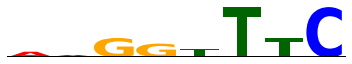

Test sequence 438:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]]
 - Prediction (original) = 7.12
 - Predictions (scrambled) = [6.93, 4.92, 5.92, 5.83, 4.94, 3.66, 6.24, 5.37, 5.5, 5.16, 5.95, 5.81, 6.39, 5.62, 5.09, 10.4, 5.51, 4.87, 6.75, 6.57, 4.84, 6.57, 4.84, 5.17, 7.52, 5.36, 5.54, 6.25, 6.03, 5.37, 5.91, 5.54]


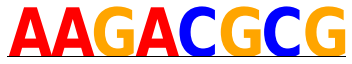

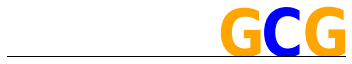

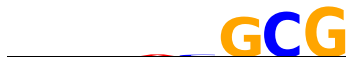

Test sequence 439:
seq (1, 1, 8, 4) [[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 1. 0.]
   [0. 1. 0. 0.]]]]
seq1 (1, 8, 4) [[[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]]]
 - Prediction (original) = 17.0
 - Predictions (scrambled) = [17.4, 16.7, 16.2, 16.8, 15.9, 15.7, 16.2, 17.2, 15.5, 13.7, 16.5, 15.2, 17.0, 16.1, 18.1, 17.1, 16.5, 14.4, 19.0, 16.1, 14.0, 12.8, 15.7, 15.7, 17.7, 14.9, 16.2, 16.7, 16.9, 16.7, 15.3, 15.6]


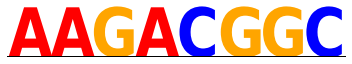

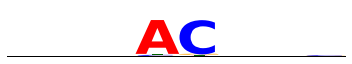

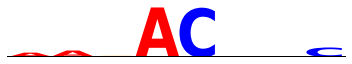

In [90]:
viz_scrambler_results(new_jtest_reload, cnn_scr, cnn=True)

In [131]:
x_test[4:5, ...][0].shape

(1, 8, 4)

In [134]:
[x_test[4:5, ...]]

[array([[[[1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [1., 0., 0., 0.]]]])]